# Chapter 18 Predicting Stock Returns Using LightGBM: A Quantitative Approach

## Introduction

Accurate prediction of stock returns provides a competitive edge for traders and portfolio managers. Traditional models, while foundational, often struggle to capture the complexity and non-linear relationships inherent in financial markets. Machine learning, particularly advanced algorithms like LightGBM (Light Gradient Boosting Machine), has emerged as a transformative tool, enabling the integration of financial theory with data-driven insights.

LightGBM is an efficient machine learning algorithm designed for high-dimensional data, offering speed and precision. Its ability to handle large, complex datasets makes it particularly well-suited for financial applications. In this study, we demonstrate how LightGBM can be used to forecast stock returns, leveraging Tiingo’s financial data and a simple long-only strategy.

## Traditional Drivers of Stock Returns

The performance of firms is closely linked to their fundamental characteristics, as demonstrated by seminal research in asset pricing. **Fama and French (1992)** showed that value (book-to-market) and size factors explain cross-sectional stock returns, while **Jegadeesh and Titman (1993)** introduced momentum as another key driver. These findings have become cornerstones of factor-based investing, though their persistence and practical application continue to be debated (**Harvey et al., 2016**).

## The Role of Machine Learning in Stock Prediction

The rise of machine learning has revolutionized quantitative finance, enabling the analysis of vast datasets with unprecedented precision. While traditional models rely on linear relationships and a limited set of factors, machine learning captures complex, non-linear patterns. 

## LightGBM: Why Boosted Trees Are Effective

LightGBM is built on gradient boosting, an ensemble technique where weak learners (decision trees) are sequentially trained to correct errors. This results in a robust model capable of handling high-dimensional, sparse datasets—common in finance. Its efficiency and flexibility make it a powerful tool for predicting stock returns, enabling portfolio managers to gain deeper insights and improve decision-making.

*Note: The backtesting results presented in this study are based on historical data and are for illustrative purposes only. They are not indicative of future performance and should not be interpreted as investment advice. Real-world trading involves additional risks, including but not limited to transaction costs, market impact, and changes in market conditions, which may significantly affect outcomes. Past performance does not guarantee future results.*

---


## Data Acquisition

We gather daily price data and quarterly stock characteristics for the top 100 U.S. stocks by market capitalization, covering the period from January 2000 to December 2024 (refer to the appendix for the code to download stock tickers). This dataset comprises common equities, ensuring high-quality and consistent data. Using Tiingo’s premium packages, we access point-in-time data, which eliminates survivorship bias—a critical step for ensuring robust backtesting.

Our goal is to predict 1-month future returns, leveraging a set of selected features, including fundamental, momentum, and volume-based metrics. While our primary focus is on 1-month returns, we use the 12-month Sharpe ratio as the label to evaluate the risk-adjusted performance of our predictions. This approach simplifies the process while demonstrating that even relatively simple strategies, combined with quality data, can deliver strong predictive performance.

To prevent look-ahead bias, we use a 36-month rolling window for training, ensuring that only historical data informs our predictions. Each iteration requires a minimum of 48 months of data: 36 months for training and 12 months for the prediction horizon. The model is retrained monthly, with the holding period aligned to a monthly cadence.

In [ ]:
#pip install tiingo

In [ ]:
# Standard Libraries
import os                # For interacting with the operating system
import pickle            # For serializing Python objects
from io import StringIO  # For in-memory string-based file operations

# Third-Party Libraries
import pandas as pd      # For data manipulation and analysis
from tiingo import TiingoClient  # For accessing Tiingo's financial data

In [ ]:
# Set your Tiingo API key
os.environ['TIINGO_API_KEY'] = "TIINGO_API_KEY"  # Store your Tiingo API key as an environment variable.

In [ ]:
def initialize_tiingo_client():
    """
    Initializes and returns a TiingoClient object using the API key from environment variables.

    Returns:
        TiingoClient: An instance of the TiingoClient configured with the provided API key.

    Raises:
        Exception: If the 'TIINGO_API_KEY' environment variable is not set.
    """
    config = {
        'session': True,  
        'api_key': os.getenv('TIINGO_API_KEY'),  # Retrieve the API key from the environment variable
        'timeout': 10  # Set a timeout of 10 seconds for API requests
    }
    if not config['api_key']:
        raise Exception("Tiingo API key not found. Please set the 'TIINGO_API_KEY' environment variable.")
    return TiingoClient(config)

In [ ]:
def clear_directory(dir_path, file_extension="pickle"):
    """
    Clears all files with a specific extension in a given directory.

    Parameters:
        dir_path (str): Path to the directory to clear.
        file_extension (str): File extension to target (default is "pickle").

    Returns:
        None
    """
    # Check if the directory exists
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"The directory '{dir_path}' does not exist.")

    # Check if the provided path is a directory
    if not os.path.isdir(dir_path):
        raise NotADirectoryError(f"'{dir_path}' is not a directory.")

    # List all files in the directory with the specified extension
    file_list = [f for f in os.listdir(dir_path) if f.endswith(f".{file_extension}")]

    # If no files with the specified extension are found, print a message and return
    if not file_list:
        print(f"No files with extension '.{file_extension}' found in '{dir_path}'.")
        return

    # Iterate over each file in the list and remove it
    for f in file_list:
        file_path = os.path.join(dir_path, f)
        try:
            os.remove(file_path)
            print(f"Removed: {file_path}")
        except Exception as e:
            print(f"Failed to remove {file_path}: {e}")

    print(f"Cleared {len(file_list)} files with extension '.{file_extension}' from '{dir_path}'.")

In [ ]:
def read_tickers_from_file(file_path):
    """
    Reads stock tickers from a file and returns them as a list.

    Parameters:
        file_path (str): Path to the file containing stock tickers.

    Returns:
        list: A list of stock tickers.
    """
    try:
        with open(file_path, 'r') as f:  # Open the file in read mode
            tickers = [line.strip() for line in f.readlines() if line.strip()]  # Read each line, remove leading/trailing spaces, and store non-empty lines in a list
        return tickers  # Return the list of tickers
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    except Exception as e:
        raise Exception(f"An error occurred while reading the file: {e}")

The following code outlines an efficient pipeline for acquiring and processing both daily stock price data and quarterly fundamental data via the Tiingo API. To maintain consistency in backtesting scenarios, the quarterly fundamental data is interpolated to a daily frequency using forward-filling. This approach ensures that the most recent financial metrics are carried forward and aligned with the corresponding daily price data. The result is a unified dataset that seamlessly integrates price and fundamental information, enabling robust analysis and modeling.

##### Downloading Stock Price Data
This function retrieves historical stock price data from the Tiingo API for a given list of tickers. The data for each ticker is fetched individually and then consolidated into a single pandas DataFrame for ease of analysis.

In [ ]:
def download_stock_data(client, ticker_list, start_date, end_date):
    """
    Downloads historical stock price data for a list of tickers from the Tiingo API.

    Parameters:
        client (TiingoClient): An authenticated TiingoClient object.
        ticker_list (list): List of stock tickers to fetch data for.
        start_date (str): Start date for the historical data in 'YYYY-MM-DD' format.
        end_date (str): End date for the historical data in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: A combined DataFrame containing historical stock data for all tickers.
    """
    all_data_frames = []  # Create a list to store the individual DataFrames

    for ticker in ticker_list:  # Loop over each ticker symbol
        try:
            # Fetch historical stock data from Tiingo API in JSON format
            historical_data = client.get_ticker_price(
                ticker,
                fmt='json',
                startDate=start_date,
                endDate=end_date,
                frequency='daily'
            )
            
            # Convert the JSON data into a pandas DataFrame
            df = pd.DataFrame(historical_data)
            
            # Add a new column to identify which stock the data belongs to
            df['stockid'] = ticker
            
            # Reset the index to clean the DataFrame
            df.reset_index(drop=True, inplace=True)
            
            # Append the DataFrame to the list for combining later
            all_data_frames.append(df)
        
        except Exception as e:  # If an error occurs during data fetching
            print(f"Failed to fetch data for {ticker}: {e}")  # Print the error message
    
    # Combine all individual DataFrames into one
    combined_df = pd.concat(all_data_frames, ignore_index=True)
    
    return combined_df  # Return the combined DataFrame

##### Downloading Stock Fundamentals Data
This function retrieves quarterly fundamental data (e.g., financial statement items such as revenue, earnings, and balance sheet metrics) for each ticker from the Tiingo API. The data is then reshaped into a structured format, and missing dates are forward-filled to align with daily frequency. Finally, the data for all tickers is combined into a single pandas DataFrame, ensuring seamless integration with daily stock price data for analysis and modeling

In [ ]:
import pandas as pd

def download_fundamentals(client, ticker_list, start_date, end_date):
    """
    Downloads and processes fundamental data for a list of tickers from the Tiingo API.

    Parameters:
        client (TiingoClient): An authenticated TiingoClient object.
        ticker_list (list): List of stock tickers to fetch data for.
        start_date (str): Start date for the data in 'YYYY-MM-DD' format.
        end_date (str): End date for the data in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: A combined DataFrame containing processed fundamental data for all tickers.
    """
    # Initialize an empty DataFrame to store all data
    combined_df = pd.DataFrame()

    # Loop through each ticker
    for ticker in ticker_list:
        try:
            # Fetch fundamental data from Tiingo API
            fundamentals_stmnts = client.get_fundamentals_statements(
                ticker,
                startDate=start_date,
                endDate=end_date,
                asReported=True,  # Ensure it's as reported by SEC
                fmt='json'
            )

            # Skip if no data is returned for the ticker
            if not fundamentals_stmnts:
                print(f"No data for {ticker}.")
                continue

            # Create a list to store rows of the final DataFrame
            data_rows = []

            for record in fundamentals_stmnts:
                date = record['date']
                year = record['year']
                quarter = record['quarter']

                # Skip records without statement data
                if 'statementData' not in record:
                    continue

                statement_data = record['statementData']

                # Extract and flatten each financial statement category
                for category in ['incomeStatement', 'balanceSheet', 'cashFlow', 'overview']:
                    if category in statement_data:
                        for item in statement_data[category]:
                            data_code = item.get('dataCode')
                            value = item.get('value')
                            if data_code:  # Only include rows with valid data codes
                                data_rows.append({
                                    'date': date,
                                    'year': year,
                                    'quarter': quarter,
                                    'stockid': ticker,
                                    'dataCode': data_code,
                                    'value': value
                                })

            # Skip if no valid rows were collected
            if not data_rows:
                print(f"No valid data rows for {ticker}.")
                continue

            # Convert the list of rows into a DataFrame
            df = pd.DataFrame(data_rows)

            # Remove records where quarter is 0 (not quarterly data)
            df = df[df['quarter'] != 0]

            # Pivot the DataFrame to reshape it
            df = df.pivot(index=['date', 'year', 'quarter', 'stockid'], columns='dataCode', values='value')
            df.reset_index(inplace=True)  # Reset the index

            # Convert 'date' column to datetime format
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

            # Filter out rows where 'date' conversion failed
            df = df.dropna(subset=['date'])

            # Set the 'date' column as the index for reindexing
            df.set_index('date', inplace=True)

            # Create a full date range between the start and end date
            full_date_range = pd.date_range(start=df.index.min(), end=end_date, freq='D')

            # Reindex the DataFrame with the full date range and forward-fill missing values
            df = df.reindex(full_date_range).ffill()

            # Reset the index after reindexing
            df.reset_index(inplace=True)

            # Rename the index column back to 'date'
            df.rename(columns={'index': 'date'}, inplace=True)

            # Reassign the 'stockid' column after resetting the index
            df['stockid'] = ticker

            # Combine with the existing DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)

        except Exception as e:
            print(f"Error for {ticker}: {e}")

    # Return the combined DataFrame after processing all tickers
    return combined_df

In [ ]:
def save_as_pickle(df, file_path):
    """
    Saves a pandas DataFrame as a pickle file.

    Parameters:
        df (pd.DataFrame): The DataFrame to be saved.
        file_path (str): The path (including filename) where the pickle file will be saved.

    Raises:
        ValueError: If the input is not a pandas DataFrame.
        IOError: If the file cannot be written to the specified path.
    """
    # Check if the input is a pandas DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    try:
        # Open the file in binary write mode and save the DataFrame
        with open(file_path, 'wb') as f:
            pickle.dump(df, f)
        print(f"DataFrame successfully saved to {file_path}.")
    except Exception as e:
        raise IOError(f"Failed to save DataFrame to {file_path}: {e}")

In [ ]:
# Define the target directory
target_directory = "YOUR DIRECTORY"

# Clear old .pickle files from the target directory
try:
    print("Clearing old files from the target directory...")
    clear_directory(target_directory, file_extension="pickle")  
except Exception as e:
    print(f"Error clearing directory: {e}")
    exit(1)

In [ ]:
if __name__ == '__main__':
    # Define the target directory to store the data files
    target_directory = "YOUR DIRECTORY"
    
    try:
        # Change the current working directory to the target directory
        os.chdir(target_directory)
        print(f"Changed working directory to: {target_directory}")
    except FileNotFoundError:
        print(f"Error: The directory '{target_directory}' does not exist.")
        exit(1)
    except Exception as e:
        print(f"Error changing directory: {e}")
        exit(1)

    # Initialize the Tiingo client
    try:
        client = initialize_tiingo_client()
        print("Tiingo client initialized successfully.")
    except Exception as e:
        print(f"Error initializing Tiingo client: {e}")
        exit(1)

    # Define the path to the text file containing tickers
    ticker_file_path = os.path.join(target_directory, "Stock_Tickers.txt")
    
    try:
        # Read tickers from the text file
        US_tickers = read_tickers_from_file(ticker_file_path)
        print(f"Successfully read {len(US_tickers)} tickers from {ticker_file_path}.")
    except Exception as e:
        print(f"Error reading tickers from file: {e}")
        exit(1)

    # Define the start and end dates for downloading stock data
    start_date = '2000-01-01'
    end_date = '2025-02-01'

    # Download stock price data
    try:
        print("Downloading stock price data...")
        stock_price_data = download_stock_data(client, US_tickers, start_date, end_date)
        print("Stock price data downloaded successfully.")
    except Exception as e:
        print(f"Error downloading stock price data: {e}")
        exit(1)

    # Save the stock price data as a pickle file
    stock_price_file_path = os.path.join(target_directory, "US_Combined_Stock_Price.pickle")
    try:
        save_as_pickle(stock_price_data, stock_price_file_path)
        print(f"Stock price data saved to {stock_price_file_path}.")
    except Exception as e:
        print(f"Error saving stock price data: {e}")
        exit(1)

    # Download fundamental data
    try:
        print("Downloading fundamental data...")
        fundamentals_data = download_fundamentals(client, US_tickers, start_date, end_date)
        print("Fundamental data downloaded successfully.")
    except Exception as e:
        print(f"Error downloading fundamental data: {e}")
        exit(1)

    # Save the fundamental data as a pickle file
    fundamentals_file_path = os.path.join(target_directory, "US_Combined_Stock_Fundamentals.pickle")
    try:
        save_as_pickle(fundamentals_data, fundamentals_file_path)
        print(f"Fundamental data saved to {fundamentals_file_path}.")
    except Exception as e:
        print(f"Error saving fundamental data: {e}")
        exit(1)

    # Print a success message
    print("Data download and pickle file save completed successfully.")

In [ ]:
from IPython.display import display

def load_pickle(file_path):
    """
    Loads a Python object from a pickle file.

    Parameters:
        file_path (str): Path to the pickle file.

    Returns:
        object: The Python object stored in the pickle file.

    Raises:
        FileNotFoundError: If the file does not exist.
        Exception: If an error occurs during loading.
    """
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    except Exception as e:
        raise Exception(f"Error loading pickle file '{file_path}': {e}")

if __name__ == '__main__':
    # Define the target directory
    target_directory = "YOUR DIRECTORY"

    # Define paths to pickle files
    stock_price_pickle = os.path.join(target_directory, "US_Combined_Stock_Price.pickle")
    stock_fundamentals_pickle = os.path.join(target_directory, "US_Combined_Stock_Fundamentals.pickle")

    # Load stock price data
    try:
        print("Loading stock price data...")
        stock_price_data = load_pickle(stock_price_pickle)
        print("Stock price data loaded successfully.")
    except Exception as e:
        print(e)
        stock_price_data = None

    # Load fundamentals data
    try:
        print("Loading fundamentals data...")
        stock_fundamentals_data = load_pickle(stock_fundamentals_pickle)
        print("Fundamentals data loaded successfully.")
    except Exception as e:
        print(e)
        stock_fundamentals_data = None

    # Display sample data if loaded
    if stock_price_data is not None:
        print("\nTop 500 rows of Stock Price Data:")
        display(stock_price_data.head(500))
    else:
        print("Stock price data is not available.")

    if stock_fundamentals_data is not None:
        print("\nTop 500 rows of Fundamentals Data:")
        display(stock_fundamentals_data.head(500))
    else:
        print("Fundamentals data is not available.")

    # Check if both datasets are loaded
    if stock_price_data is None or stock_fundamentals_data is None:
        print("Error: One or more datasets failed to load. Exiting.")
        exit(1)

    # Convert 'date' columns to datetime
    try:
        print("\nConverting 'date' columns to datetime...")
        stock_price_data['date'] = pd.to_datetime(stock_price_data['date']).dt.tz_localize(None)
        stock_fundamentals_data['date'] = pd.to_datetime(stock_fundamentals_data['date'])
        print("Date conversion completed successfully.")
    except Exception as e:
        print(f"Error converting 'date' columns: {e}")
        exit(1)

    # Merge datasets
    try:
        print("\nMerging datasets...")
        merged_data = pd.merge(
            stock_price_data,
            stock_fundamentals_data,
            on=['stockid', 'date'],
            how='inner'
        )
        merged_data = merged_data.sort_values(by=['stockid', 'date'])
        print("Datasets merged successfully.")
    except Exception as e:
        print(f"Error merging datasets: {e}")
        exit(1)

    # Display merged dataset columns
    print("\nColumns in the merged dataset:")
    print(merged_data.columns)

---

## Feature and Label Engineering


With tree-based models like LightGBM, highly correlated variables don’t disrupt performance. In fact, incorporating many correlated features gives the model flexibility to discern the unique contribution of each variable (**Coqueret and Guida, 2019, 2020**). In our model, we use well-known financial factors such as:

- Market Capitalization
- Price-to-Book Ratio
- Momentum
- Profitability
- Growth
- Risk (Volatility)

The dataset is not static—company attributes and the number of available stocks vary over time, making the backtesting process more complex. However, this variability mirrors the dynamic nature of real markets, allowing for more accurate and robust analysis. This approach ensures that our model adapts to changing conditions, enhancing its practical relevance.



*Note: Coqueret and Guida (2020) implemented a strategy using Xgboost that filters stocks based on having data for the maximum number of dates available in the dataset. This approach ensures that only stocks with complete data for all time points are considered. While this method has its merits, we chose not to adopt it in our analysis due to potential concerns about survivorship bias.*

**Feature Engineering**

In [ ]:
merged_data = merged_data.sort_values(by=['stockid', 'date'])

In [ ]:
merged_data['MKTCAP'] = merged_data['shareswa'] * merged_data['close'] # Here we cannot use adjclose (due to look-ahead bias)

In [ ]:
merged_data['ASSET_TURNOVER'] = merged_data['revenue'] / merged_data['totalAssets']

In [ ]:
merged_data['INVENTORY_TURNOVER'] = merged_data['costRev'] / merged_data['inventory']

In [ ]:
merged_data['REC_TURNOVER'] = merged_data['revenue'] / merged_data['acctRec']

In [ ]:
merged_data['PAYABLES_TURNOVER'] = merged_data['costRev'] / merged_data['acctPay']

In [ ]:
merged_data['EBIT_SALE'] = merged_data['ebit'] / merged_data['revenue']

In [ ]:
merged_data['EBITDA_SALE'] = merged_data['ebitda'] / merged_data['revenue']

In [ ]:
merged_data['NET_MARGIN'] = merged_data['netinc'] / merged_data['revenue']

In [ ]:
merged_data['NI_AT'] = merged_data['netinc'] / merged_data['totalAssets']

In [ ]:
merged_data['EPS'] = merged_data['eps']

In [ ]:
merged_data['EPS_DIL'] = merged_data['epsDil']

In [ ]:
merged_data['EPS_GR'] = merged_data.groupby('stockid')['eps'].pct_change(252, fill_method=None)

In [ ]:
merged_data['FCF'] = merged_data['freeCashFlow']

In [ ]:
merged_data['FCF_BV'] = merged_data['freeCashFlow'] / merged_data['equity']

In [ ]:
merged_data['FCF_SALE'] = merged_data['freeCashFlow'] / merged_data['revenue']

In [ ]:
merged_data['FCF_TA'] = merged_data['freeCashFlow'] / merged_data['totalAssets']

In [ ]:
merged_data['FCF_YIELD'] = merged_data['freeCashFlow'] / merged_data['MKTCAP']

In [ ]:
merged_data['OCF_SALES'] = merged_data['ncfo'] / merged_data['revenue']

In [ ]:
merged_data['PB'] = merged_data['MKTCAP'] / merged_data['equity']

In [ ]:
merged_data['PE'] = merged_data['close'] / merged_data['eps']

In [ ]:
merged_data['DEBT_EQUITY'] = merged_data['debt'] / merged_data['equity']

In [ ]:
merged_data['INT_COVERAGE'] = merged_data['ebit'] / merged_data['intexp']

In [ ]:
merged_data['MOM_12M_USD'] = merged_data.groupby('stockid')['close'].pct_change(252)

In [ ]:
merged_data['VOL12M_USD'] = (
    merged_data.groupby('stockid')['close'].pct_change().rolling(window=252).std().reset_index(0, drop=True) * (252 ** 0.5)
)

In [ ]:
merged_data['MOM_SHARPE_12M_USD'] = merged_data['MOM_12M_USD'] / merged_data['VOL12M_USD']

In [ ]:
merged_data['SHARE_TURN_12M'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=252).mean().reset_index(0, drop=True)
) / merged_data.groupby('stockid')['shareswa'].rolling(window=252).mean().reset_index(0, drop=True)

In [ ]:
merged_data['ADV_12M_USD'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=252).mean().reset_index(0, drop=True)
    * merged_data['close']
)

**Labels Section**

In [ ]:
# Sort data by stockid and date
merged_data = merged_data.sort_values(by=['stockid', 'date'])

# 1-Month Forward Return
merged_data['R1M_USD'] = (
    merged_data.groupby('stockid')['close'].shift(-21) / merged_data['close'] - 1
)

# 1-Year Forward Return
merged_data['R1Y_USD'] = (
    merged_data.groupby('stockid')['close'].shift(-252) / merged_data['close'] - 1
)

# 1-Year Forward Volatility
merged_data['VOL1Y_USD'] = (
    merged_data.groupby('stockid')['close']
    .pct_change()  # Daily returns
    .rolling(window=252)  # Rolling window of 252 days
    .std()  # Standard deviation of returns
    .shift(-252)  # Shift to align with future returns
    * (252 ** 0.5)  # Annualize volatility
)

# 1-Year Forward Sharpe Ratio (using excess returns)
risk_free_rate = 0.02  # Example: 2% annual risk-free rate
merged_data['SHARPE_1Y_USD'] = (merged_data['R1Y_USD'] - risk_free_rate) / merged_data['VOL1Y_USD']

By selecting 1-year Sharpe Ratio as the label, we provide the model with a more reliable basis for identifying the relationships between the input features and the label (target), which is enough for having a certain degree of causality between the nature of the features in the datasets and the tenor of the labels (Coqueret and Guida, 2019, 2020).

In [ ]:
# Saving the final dataset to a pickle file in the default directory
merged_data.to_pickle('Stock_Financials_Raw.pickle')

In [ ]:
column_names = [col for col in merged_data.columns]
print(column_names)

*Note: The Federal Reserve Bank of St. Louis (https://fred.stlouisfed.org) offers access to many economic time series that can serve as valuable variables for financial models. **Gu, Kelly, and Xiu (2020)** show that incorporating macroeconomic variables can notably improve model performance in asset pricing.*

---

## Data Preparation for ML Backtesting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the pickle file
file_path = 'Stock_Financials_Raw.pickle'
df = pd.read_pickle(file_path)

In [ ]:
# Define the predictors and label
predictors = [
    'MKTCAP',                  # Market Capitalization
    'ASSET_TURNOVER',           # Asset Turnover
    'INVENTORY_TURNOVER',       # Inventory Turnover
    'REC_TURNOVER',             # Receivables Turnover
    'PAYABLES_TURNOVER',        # Payables Turnover
    'EBIT_SALE',                # EBIT Margin
    'EBITDA_SALE',              # EBITDA Margin
    'NET_MARGIN',               # Net Margin
    'NI_AT',                    # Net Income to Total Assets
    'EPS',                      # Earnings Per Share
    'EPS_DIL',                  # Diluted Earnings Per Share
    'EPS_GR',                   # EPS Growth (YoY Change)
    'FCF',                      # Free Cash Flow
    'FCF_BV',                   # Free Cash Flow to Book Value
    'FCF_SALE',                 # Free Cash Flow to Sales
    'FCF_TA',                   # Free Cash Flow to Total Assets
    'FCF_YIELD',                # Free Cash Flow Yield
    'OCF_SALES',                # Operating Cash Flow to Sales
    'PB',                       # Price-to-Book Ratio
    'PE',                       # Price-to-Earnings Ratio
    'DEBT_EQUITY',              # Debt to Equity
    'INT_COVERAGE',             # Interest Coverage Ratio
    'MOM_SHARPE_12M_USD',       # Sharpe Ratio for 12 months
    'SHARE_TURN_12M',           # 12-Month Share Turnover
    'ADV_12M_USD',              # 12-Month Average Daily Volume in USD
]

labels = [
    'R1M_USD',                  # 1-Month Forward Return in USD (predictions)
    'SHARPE_1Y_USD'             # 1-Year Forward Sharpe Ratio (label)
]

df = df[['stockid', 'date'] + predictors + labels]

**Converting the Dataset to Monthly Format**

In [ ]:
# Convert 'date' to datetime format
df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop any rows where 'date' conversion failed (optional, based on your needs)
df = df.dropna(subset=['date'])

# Sort the dataframe by 'stockid' and 'date' to prepare for resampling
df = df.sort_values(by=['stockid', 'date'])

# Set 'date' as the index for resampling, but keep 'stockid' as a column
df.set_index('date', inplace=True)

# Group by 'stockid' and resample the data by the last day of the month
df_resampled = df.groupby('stockid', group_keys=False).resample('ME').last()

df_resampled.reset_index(inplace=True)

In [ ]:
import numpy as np
# Replace infinite values with NaN and drop rows where any of the predictor columns have NaN or infinite values
df_resampled[predictors] = df_resampled[predictors].replace([np.inf, -np.inf], np.nan)
df_resampled = df_resampled.dropna(subset=predictors)

In [ ]:
# Convert 'date' to datetime for easier manipulation
df_resampled['date'] = pd.to_datetime(df_resampled['date'])

# Extract 'year' and 'month' from the 'date' column
df_resampled['year'] = df_resampled['date'].dt.year
df_resampled['month'] = df_resampled['date'].dt.month

# Group the data by 'year' and 'month' and for each group, select the top 100 stocks by MKTCAP
df_resampled = df_resampled.groupby(['year', 'month']).apply(lambda x: x.nlargest(100, 'MKTCAP')).reset_index(drop=True)
df_resampled.drop(columns=['year', 'month'], inplace=True)
df_resampled = df_resampled.sort_values(by=['stockid', 'date']).reset_index(drop=True)

**Winsorization** is used to reduce the influence of extreme values (outliers) in the dataset. The winsorization stage must be performed on a feature-by-feature and a date-by-date basis.

At each point in time, the cross-sectional distribution of every feature is also **standardized uniformly within a unit interval**. In factor investing, it’s essential to scale the features separately for each date and feature. This process ensures that at every rebalancing date, the predictors retain their consistency and accurately reflect the stock cross-section. Scaling features across different dates, on the other hand, can lead to distortions (Coqueret and Guida, 2020). 

In [ ]:
from scipy.stats import mstats, rankdata

# List of columns to exclude from winsorization
exclude_columns = ['stockid', 'date']

# Apply winsorization feature by feature and date by date
for col in df_resampled.columns:
    if col not in exclude_columns and df_resampled[col].dtype != 'object':  # Skip excluded and non-numeric columns
        # Apply winsorization to each feature, grouped by date, while ignoring NaN values
        df_resampled[col] = df_resampled.groupby('date')[col].transform(
            lambda x: pd.Series(mstats.winsorize(x, limits=[0.05, 0.05], nan_policy='omit'), index=x.index)
        )

# List of columns to exclude from uniformization (including the label)
exclude_uniform_columns = ['stockid', 'date', 'SHARPE_1Y_USD', 'R1M_USD']

# Apply uniformization (empirical CDF transformation) feature by feature and date by date
for col in df_resampled.columns:
    if col not in exclude_uniform_columns and df_resampled[col].dtype != 'object':  # Skip excluded and non-numeric columns
        # Apply empirical CDF to each feature, grouped by date, handling NaNs
        df_resampled[col] = df_resampled.groupby('date')[col].transform(
            lambda x: rankdata(x.fillna(np.nan), method='average') / max((~x.isna()).sum(), 1)
        )

# Validate the final dataframe
print("Final Data Summary:")
print(df_resampled.head())

Coqueret and Guida (2020) show that focusing on extreme values can improve out-of-sample accuracy for decision trees. By filtering the data to keep only the top 20% and bottom 20% of label values and discarding the middle 60%, the decision tree’s performance can be enhanced.

However, Coqueret and Guida (2020) caution against overly intense filtering, as it can lead to signal loss and deteriorate performance. 

In the code below, we apply this technique to the `SHARPE_1M_USD` label, keeping only the top 20% and bottom 20% of values.


In [ ]:
label_column = 'SHARPE_1Y_USD'

# Calculate the 20th and 80th percentiles
lower_bound = df_resampled[label_column].quantile(0.20)
upper_bound = df_resampled[label_column].quantile(0.80)

# Filter rows where SHARPE_1Y_USD is outside the 20th to 80th percentile range, but keep NaN rows
df_resampled = df_resampled[(df_resampled[label_column] <= lower_bound) | 
                                     (df_resampled[label_column] >= upper_bound) |
                                     (df_resampled[label_column].isna())]

In [ ]:
# Check for duplicates based on stockid and date
duplicate_rows = df_resampled[df_resampled.duplicated(subset=['stockid', 'date'], keep=False)]

# Display the duplicate rows (if any)
print(duplicate_rows)

In [ ]:
# Save the DataFrame as a pickle file
df_resampled.to_pickle("df_ml.pickle")

---

## Backtesting and Performance Evaluation

**Portfolio Backtesting**

Portfolio backtesting is often viewed as a quest to identify the best strategy— or at least a consistently profitable one (Coqueret and Guida, 2020). In this analysis, we focus on two strategies: one machine learning (ML)-based and an equally weighted (EW) benchmark (1/N). We employ an equally weighted (EW) portfolio as the benchmark since such portfolios are known to be particularly difficult to outperform. 


*Note: The following code shows a **rolling backtest** strategy using LightGBM as the machine learning model. The strategy includes the use of historical data for training, a gap between training and test periods (referred to as the **danger zone**), and a monthly rebalancing scheme for portfolio construction. Below is a detailed explanation of the key steps and time periods involved.*

**Data Preprocessing**
- The dataset is loaded, and specific financial metrics (predictors) are selected as features.
- The target variable for training is defined as the **1-year Sharpe ratio (`SHARPE_1Y_USD`)**, and the realized returns for validation are defined as `R1M_USD`.

**Training Sample Period**
- **Training Window Size:** For each iteration (monthly backtest), the model is trained on a **3-year (36-month) rolling window** of past data. This means that, at each step, the model uses 36 months of historical data to train on the target variable (`SHARPE_1Y_USD`).
- **Danger Zone (Gap between Training and Test):** There is a **12-month gap** between the end of the training period and the start of the test period, referred to as the danger zone. This gap ensures that the training data uses only historical data without overlapping into the testing period.


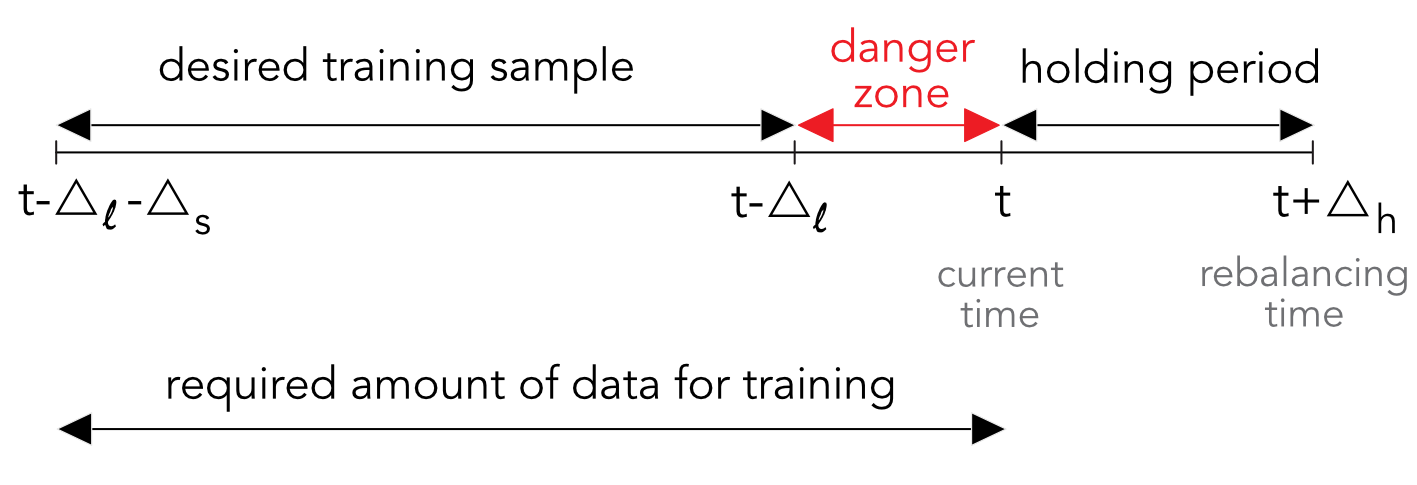

*Picture Source: Coqueret, G., & Guida, T. (2020). Machine Learning for Factor Investing: R Version. Chapman and Hall/CRC.*

**Test Period (Holding Period)**
- **Test Window:** The test data consists of **one month** at a time, immediately after the danger zone. The model predicts the **Sharpe ratio** for each stock for the next 12 months.
- **Holding Period:** The holding period for each iteration is **one month**, meaning that after the model predicts the stocks' Sharpe ratios, the portfolio is held for one month until the next rebalancing.

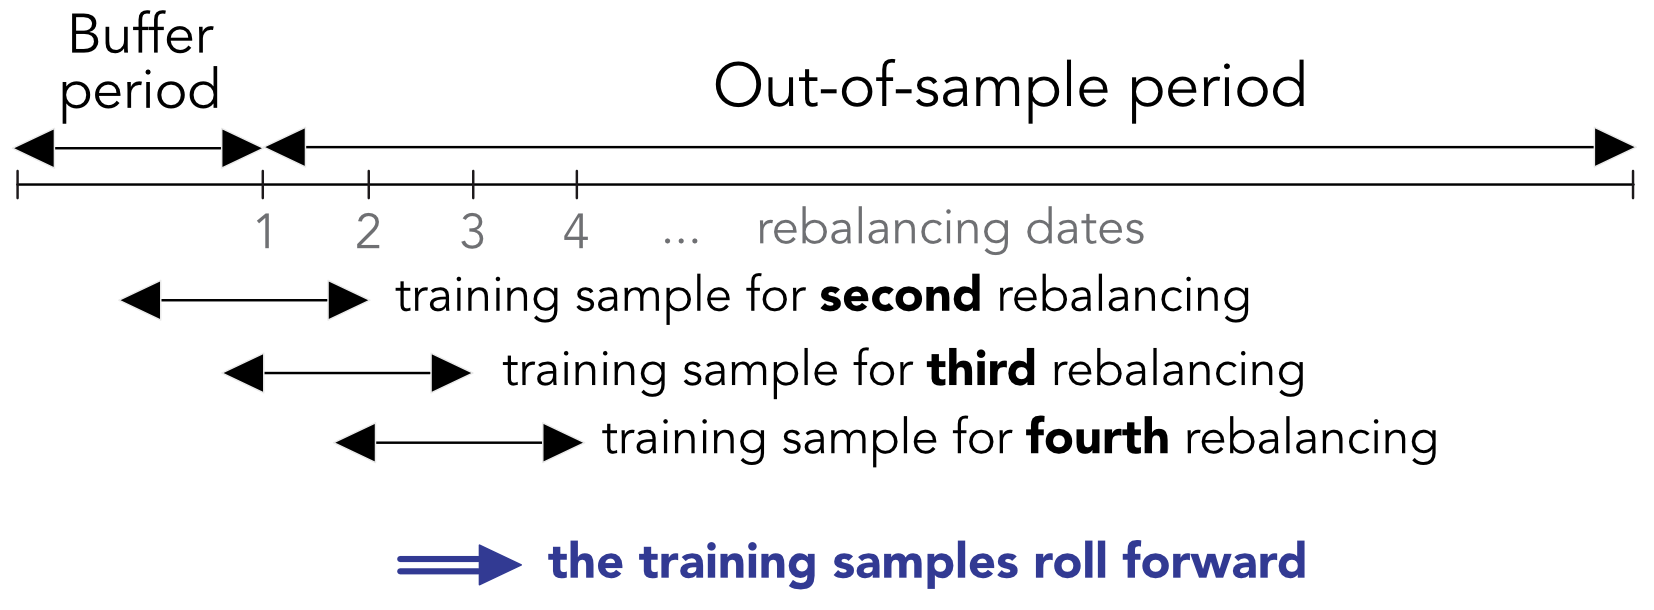

*Picture Source: Coqueret, G., & Guida, T. (2020). Machine Learning for Factor Investing: R Version. Chapman and Hall/CRC.*

**Portfolio Construction**
- **Equal-Weighted Portfolio (EW):** All stocks in the test month are weighted equally. This strategy serves as a baseline for comparison.
- **ML-Based Portfolio:** For the ML-based portfolio, the model selects the top 50% of stocks (based on predicted Sharpe ratios), and the portfolio weights are distributed equally across these selected stocks.
- **Realized Returns:** After selecting the stocks and computing the weights, the actual (realized) returns (`R1M_USD`) for the next month are used to calculate the portfolio's performance.

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'df_ml.pickle'
df = pd.read_pickle(file_path)
df = df[df['date'] < '2025-02-01']

# Define the predictors and label (SHARPE_1Y_USD)
predictors = [
    'MKTCAP',                  # Market Capitalization
    'ASSET_TURNOVER',           # Asset Turnover
    'INVENTORY_TURNOVER',       # Inventory Turnover
    'REC_TURNOVER',             # Receivables Turnover
    'PAYABLES_TURNOVER',        # Payables Turnover
    'EBIT_SALE',                # EBIT Margin
    'EBITDA_SALE',              # EBITDA Margin
    'NET_MARGIN',               # Net Margin
    'NI_AT',                    # Net Income to Total Assets
    'EPS',                      # Earnings Per Share
    'EPS_DIL',                  # Diluted Earnings Per Share
    'EPS_GR',                   # EPS Growth (YoY Change)
    'FCF',                      # Free Cash Flow
    'FCF_BV',                   # Free Cash Flow to Book Value
    'FCF_SALE',                 # Free Cash Flow to Sales
    'FCF_TA',                   # Free Cash Flow to Total Assets
    'FCF_YIELD',                # Free Cash Flow Yield
    'OCF_SALES',                # Operating Cash Flow to Sales
    'PB',                       # Price-to-Book Ratio
    'PE',                       # Price-to-Earnings Ratio
    'DEBT_EQUITY',              # Debt to Equity
    'INT_COVERAGE',             # Interest Coverage Ratio
    'MOM_SHARPE_12M_USD',       # Sharpe Ratio for 12 months
    'SHARE_TURN_12M',           # 12-Month Share Turnover
    'ADV_12M_USD',              # 12-Month Average Daily Volume in USD
]

label = 'SHARPE_1Y_USD'  # Label (target to train on)
prediction_target = 'R1M_USD'

# Ensure stockid is treated as categorical or numeric (convert stockid if it's a string)
df['stockid'] = pd.factorize(df['stockid'])[0]

# Sort data by stockid and date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['stockid', 'date'])

# Generate the full range of monthly test dates, filling missing ones
sep_oos = pd.to_datetime("2016-01-01")  # Starting point for backtest: 2016, the year LightGBM was launched, to demonstrate its use in predicting stock returns post-launch
last_date = df['date'].max()
t_oos_full = pd.date_range(start=sep_oos, end=last_date, freq='ME')

# Initialize portfolio weights and returns
Tt = len(t_oos_full)
nb_port = 2  # Number of portfolios/strategies (EW and LGBM)
max_stocks = df['stockid'].nunique()
portf_weights = np.zeros((Tt, nb_port, max_stocks))  # Weights per strategy
portf_returns = np.zeros((Tt, nb_port))  # Portfolio returns

#These LightGBM parameters are set for illustrative purposes
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 128,
    'max_depth': 15,
    'learning_rate': 0.01,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1
}

# Define parameters for rolling window
m_offset = 12  # Offset in months for label
train_size = 3  # Size of training set in years

# Backtesting loop
for t in range(len(t_oos_full)):
    print(f'Backtesting date: {t_oos_full[t]}')
    
    train_end_date = t_oos_full[t] - pd.DateOffset(months=m_offset)
    train_start_date = train_end_date - pd.DateOffset(years=train_size)

    # Training data: past cross-sectional data (3 years)
    train_data = df[(df['date'] > train_start_date) & (df['date'] <= train_end_date)]

    # Test data: the next month's cross-sectional data
    test_data = df[df['date'] == t_oos_full[t]]
    
    if test_data.empty:
        print(f"No test data found for date: {t_oos_full[t]}")
        continue

    realized_returns = test_data[prediction_target]
    
    train_X = train_data[predictors]
    test_X = test_data[predictors]
    
    train_y = train_data[label]  # Label is SHARPE_1Y_USD
    
    # Train LightGBM model
    dtrain = lgb.Dataset(train_X, label=train_y)
    model = lgb.train(lgb_params, dtrain, num_boost_round=500)

    # Make predictions
    pred = model.predict(test_X)
    
    # Portfolio construction
    for j in range(nb_port):
        if j == 0:
            # Equal-weighted portfolio
            N = len(test_data['stockid'])
            weights = np.repeat(1 / N, N)
            stocks = test_data['stockid'].values
        else:
            # LightGBM-based portfolio (top 50% predictions)
            top_pred = pred > np.percentile(pred, 50)
            if np.sum(top_pred) == 0:
                print(f"No stocks selected for date: {t_oos_full[t]}")
                weights = np.repeat(1 / len(test_data), len(test_data))  # Fallback to equal weights
            else:
                weights = np.where(top_pred, 1 / np.sum(top_pred), 0)
            stocks = test_data['stockid'].values

        # Store portfolio weights and returns
        portf_weights[t, j, stocks] = weights
        portf_returns[t, j] = np.sum(weights * realized_returns)

Backtesting date: 2016-01-31 00:00:00
Backtesting date: 2016-02-29 00:00:00
Backtesting date: 2016-03-31 00:00:00
Backtesting date: 2016-04-30 00:00:00
Backtesting date: 2016-05-31 00:00:00
Backtesting date: 2016-06-30 00:00:00
Backtesting date: 2016-07-31 00:00:00
Backtesting date: 2016-08-31 00:00:00
Backtesting date: 2016-09-30 00:00:00
Backtesting date: 2016-10-31 00:00:00
Backtesting date: 2016-11-30 00:00:00
Backtesting date: 2016-12-31 00:00:00
Backtesting date: 2017-01-31 00:00:00
Backtesting date: 2017-02-28 00:00:00
Backtesting date: 2017-03-31 00:00:00
Backtesting date: 2017-04-30 00:00:00
Backtesting date: 2017-05-31 00:00:00
Backtesting date: 2017-06-30 00:00:00
Backtesting date: 2017-07-31 00:00:00
Backtesting date: 2017-08-31 00:00:00
Backtesting date: 2017-09-30 00:00:00
Backtesting date: 2017-10-31 00:00:00
Backtesting date: 2017-11-30 00:00:00
Backtesting date: 2017-12-31 00:00:00
Backtesting date: 2018-01-31 00:00:00
Backtesting date: 2018-02-28 00:00:00
Backtesting 

**LGB vs Benchmark**


Performance Metrics:
          avg_ret       vol    sharpe  annualized_return  annualized_vol  \
EW       0.010235  0.045803  0.187069           0.129975        0.158666   
LGBM_SR  0.013237  0.045616  0.253639           0.170931        0.158020   

         annualized_sharpe   sortino     VaR_5  max_drawdown  
EW                0.679455  0.262057 -0.084316     -0.304659  
LGBM_SR           0.936757  0.373694 -0.074762     -0.277681  


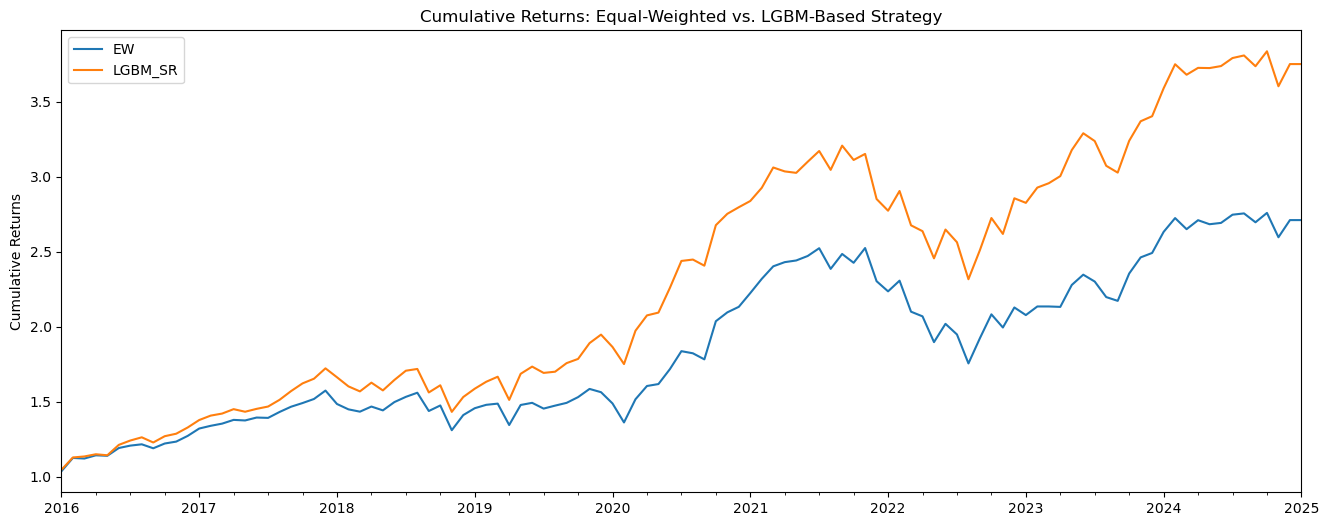

In [2]:
def calculate_performance_metrics(returns, periods_per_year=12, risk_free_rate=0.02):
    """
    Compute performance metrics for a series of periodic returns.

    Returns:
              - avg_ret: average periodic return
              - vol: standard deviation (volatility) of periodic returns
              - sharpe: periodic Sharpe ratio (excess return per unit volatility)
              - annualized_return: annualized compounded return
              - annualized_vol: annualized volatility
              - annualized_sharpe: annualized Sharpe ratio (using compounded excess return)
              - sortino: Sortino ratio (excess return over downside volatility)
              - VaR_5: 5th percentile Value-at-Risk
              - max_drawdown: Maximum drawdown over the period
    """
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    
    # Convert the annual risk-free rate to a per-period rate.
    rf_period = risk_free_rate / periods_per_year
    
    # Calculate the average periodic return and its standard deviation.
    avg_ret = np.nanmean(returns)
    vol = np.nanstd(returns, ddof=1)
    
    # Compute excess return (above the risk-free rate) on a per-period basis.
    excess_ret = avg_ret - rf_period
    sharpe = excess_ret / vol if vol != 0 else np.nan
    
    # Annualize the average return using compounding.
    annualized_return = (1 + avg_ret)**periods_per_year - 1
    
    # Annualized volatility
    annualized_vol = vol * np.sqrt(periods_per_year)
    
    # Annualize the excess return via compounding.
    annualized_excess_return = (1 + excess_ret)**periods_per_year - 1
    annualized_sharpe = annualized_excess_return / annualized_vol if annualized_vol != 0 else np.nan

    # For the Sortino ratio, compute downside volatility.
    # Downside returns are those below the per-period risk-free rate.
    downside_returns = returns - rf_period
    downside_returns = downside_returns[downside_returns < 0]
    downside_vol = np.nanstd(downside_returns, ddof=1) if len(downside_returns) > 0 else np.nan
    sortino = excess_ret / downside_vol if downside_vol != 0 else np.nan
    
    # Value-at-Risk at the 5th percentile.
    VaR_5 = np.quantile(returns, 0.05)
    
    # Calculate cumulative returns over the backtest period.
    cumulative_returns = np.cumprod(1 + returns)
    
    # Maximum Drawdown calculation:
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdowns)
    
    metrics = {
        'avg_ret': avg_ret,
        'vol': vol,
        'sharpe': sharpe,
        'annualized_return': annualized_return,
        'annualized_vol': annualized_vol,
        'annualized_sharpe': annualized_sharpe,
        'sortino': sortino,
        'VaR_5': VaR_5,
        'max_drawdown': max_drawdown,
    }
    
    return metrics

strategies = ["EW", "LGBM_SR"]
perf_metrics = {}

for j, strat in enumerate(strategies):
    perf_metrics[strat] = calculate_performance_metrics(
        portf_returns[:, j],
        periods_per_year=12,
        risk_free_rate=0.02
    )

# Convert performance metrics to a DataFrame for easy display.
perf_metrics_df = pd.DataFrame(perf_metrics).T
print("\nPerformance Metrics:")
print(perf_metrics_df)

# ------------------------------------------------------------------------------
# Plotting Cumulative Returns
# ------------------------------------------------------------------------------

# Compute cumulative returns for each strategy.
cum_returns = {}
for j, strat in enumerate(strategies):
    cum_returns[strat] = np.cumprod(1 + portf_returns[:, j])
    
cum_returns_df = pd.DataFrame(cum_returns, index=t_oos_full)
cum_returns_df.plot(figsize=(16, 6))
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns: Equal-Weighted vs. LGBM-Based Strategy")
plt.show()


---

## References

Coqueret, G., & Guida, T. (2020). Machine learning for factor investing: R version. Chapman and Hall/CRC.

Eugene, F., & French, K. (1992). The cross-section of expected stock returns. Journal of Finance, 47(2), 427-465.

Gu, S., Kelly, B., & Xiu, D. (2020). Empirical asset pricing via machine learning. The Review of Financial Studies, 33(5), 2223-2273.

Guida, T., & Coqueret, G. (2019). Ensemble learning applied to quant equity: gradient boosting in a multifactor framework. Big data and machine learning in quantitative investment, 129-148.

Harvey, C. R., Liu, Y., & Zhu, H. (2016). … and the cross-section of expected returns. The Review of Financial Studies, 29(1), 5-68.

Jegadeesh, N., & Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. The Journal of finance, 48(1), 65-91.



---

## Appendix

*This appendix provides instructions for downloading stock tickers from Tiingo*

In [ ]:
from tiingo import TiingoClient
import os

In [ ]:
def initialize_tiingo_client():
    config = {
        'session': True,
        'api_key': os.getenv('TIINGO_API_KEY')
    } 
    if not config['api_key']:
        raise Exception("API key not found! Please set your Tiingo API key as an environment variable.")
    return TiingoClient(config) 

In [ ]:
# API Key
import os
os.environ['TIINGO_API_KEY'] = "YOUR API KEY"

In [ ]:
client = initialize_tiingo_client()

In [ ]:
# Get all stock tickers
tickers_data = client.list_stock_tickers()

# Extract tickers into a list
ticker_symbols = [ticker['ticker'] for ticker in tickers_data]

In [ ]:
filtered_tickers = [
    ticker['ticker'] for ticker in tickers_data
    if ticker['assetType'] == 'Stock' and 
    ticker['priceCurrency'] == 'USD' and
    (ticker['exchange'] == 'NYSE' or ticker['exchange'] == 'NASDAQ'or ticker['exchange'] == 'AMEX')]

In [ ]:
# Save the filtered tickers to a .txt file
with open('filtered_tickers.txt', 'w') as file:
    for ticker in filtered_tickers:
        file.write(f"{ticker}\n")